In [41]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflowjs as tfjs
from keras.preprocessing import image
import glob
import numpy as np

In [29]:
import os
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "1"

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
train_root = "../alien-vs-predator-images/train"
test_root = "../alien-vs-predator-images/validation"

def image_load(image_path):
    loaded_image = image.load_img(image_path)
    image_rel = pathlib.Path(image_path).relative_to(train_root)
    print(image_rel)
    return loaded_image

We want to use the base MobileNet model as a means of extracting features.

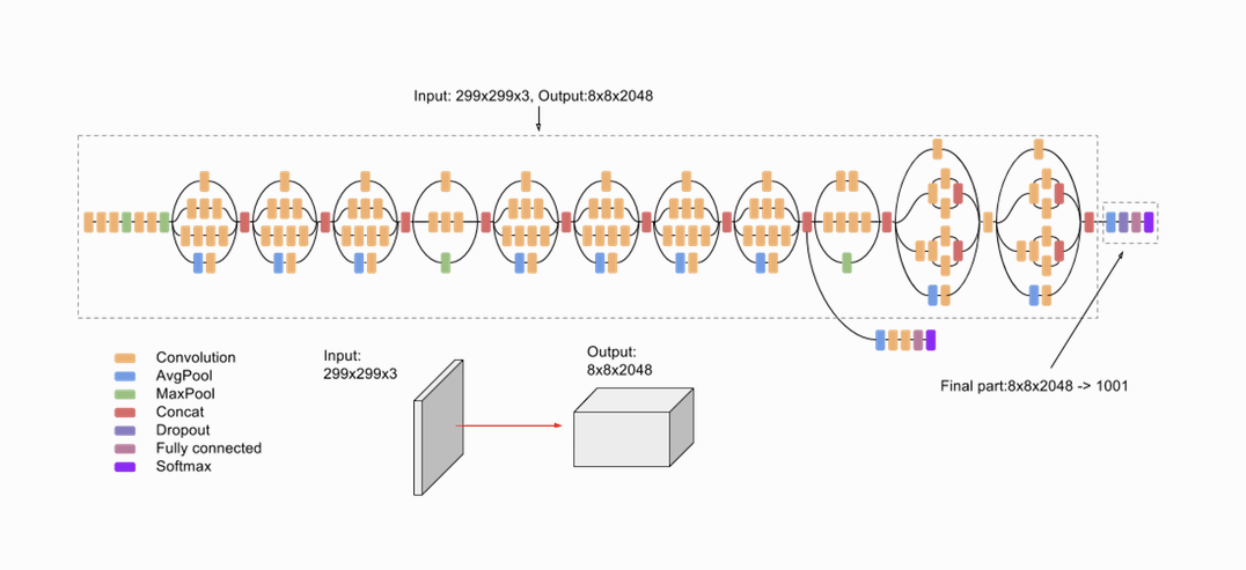

Instead of tinkering with the model directly, we can pull the feature extractor straight from TF hub

In [93]:
# Model-url
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2"

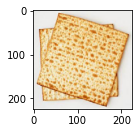

In [158]:
import matplotlib.pyplot as plt
base_path = './Data'
img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

dirname = './Data/Matzah'
fname = os.listdir(dirname)[30]


# for i, img_path in enumerate(random.sample(img_list, 6)):
img = image.load_img(os.path.join(dirname,fname), target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.subplot(2, 3, 1)
plt.imshow(img.squeeze())

In [161]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.25
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25
)

In [162]:
classes=['Matzah','Bread']
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0,
    classes=classes
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0,
    classes=classes
)

Found 1275 images belonging to 2 classes.
Found 424 images belonging to 2 classes.


In [163]:
print(train_generator.class_indices)

{'Matzah': 0, 'Bread': 1}


In [164]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

In [232]:
path = 'labels.txt'
label = np.array(open(path).read().splitlines())

In [222]:
IMG_SHAPE = (224,224,3)

In [284]:
# First try model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(classes), activation='softmax')
])
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 128)         1474688   
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 5, 128)         0         
_________________________________________________________________
global_average_pooling2d_22  (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 258       
Total params: 3,732,930
Trainable params: 1,474,946
Non-trainable params: 2,257,984
_________________________________________________________________


In [261]:
# Second try model
# base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=True, 
#                                                weights='imagenet')
# base_model.trainable = False
# IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

feature_extractor_layer = tf.keras.layers.Lambda(feature_extractor,input_shape=IMG_SHAPE)
feature_extractor_layer.trainable = False

In [262]:
# Second try model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True, 
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1000)              3538984   
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 2002      
Total params: 3,540,986
Trainable params: 2,002
Non-trainable params: 3,538,984
_________________________________________________________________


In [258]:
# Third try model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(len(classes), activation = "softmax")
    ])
model.summary()

model 

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dense_42 (Dense)             (None, 7, 7, 2)           2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [286]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), #Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [278]:
# Loss callback to quit training early
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.01)

In [279]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [287]:
batch_size = 32
epochs = 50
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator, 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=validation_generator, 
                              validation_steps=validation_steps,)

Epoch 1/50
39/39 [==============================] - 26s 591ms/step - loss: 2.6027 - accuracy: 0.8114 - val_loss: 0.5331 - val_accuracy: 0.8846
Epoch 2/50
39/39 [==============================] - 21s 537ms/step - loss: 0.4112 - accuracy: 0.9189 - val_loss: 0.3928 - val_accuracy: 0.9135
Epoch 3/50
39/39 [==============================] - 22s 547ms/step - loss: 0.3142 - accuracy: 0.9403 - val_loss: 0.7275 - val_accuracy: 0.8942
Epoch 4/50
39/39 [==============================] - 21s 537ms/step - loss: 0.1739 - accuracy: 0.9539 - val_loss: 1.1613 - val_accuracy: 0.8654
Epoch 5/50
39/39 [==============================] - 21s 528ms/step - loss: 0.2212 - accuracy: 0.9412 - val_loss: 0.1900 - val_accuracy: 0.9567
Epoch 6/50
39/39 [==============================] - 21s 537ms/step - loss: 0.3445 - accuracy: 0.9348 - val_loss: 1.1213 - val_accuracy: 0.8558
Epoch 7/50
39/39 [==============================] - 23s 589ms/step - loss: 0.3232 - accuracy: 0.9457 - val_loss: 1.5720 - val_accuracy: 0.8558

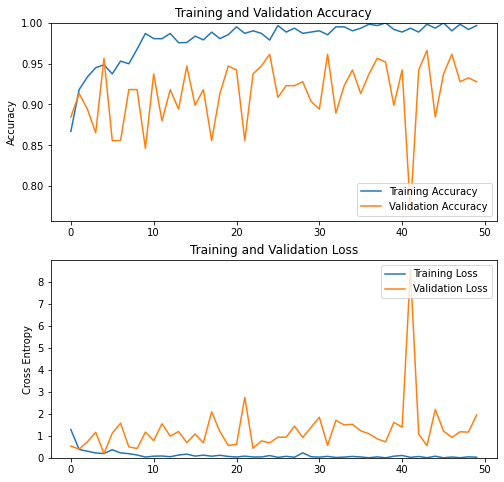

In [288]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [300]:
label

array(['Bread', 'Matzah'], dtype='<U6')

(1, 2)
[[1.0000000e+00 3.6322402e-20]]
Bread


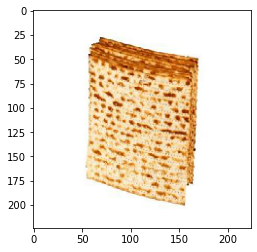

In [319]:
c = 'Matzah'
# c = 'Bread'
img_path = os.path.join('Data',c,os.listdir(os.path.join('Data',c))[0])

img=np.array(img)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=model.predict(img[np.newaxis, ...])
print(p.shape)
label[np.argmax(p[0][0], axis=-1)]
predicted_class = label[np.argmax(p[0][0], axis=-1)]
print(p)
print(predicted_class)

In [ ]:
# Save the weights
history.save_weights('./checkpoints/my_checkpoint')